# Project 2 - 2-Mode Networks - Airlines and Airports

### Betsy Rosalen and Mikhail Groysman

## Project Overview

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

## Choosing the Data

We have decide to build on the __flight data from [OpenFlights.org](https://openflights.org/data.html)__ that we used in our first project.

__OpenFlights consists of the following datasets:__

- Airports
- Airlines
- Routes
- Planes
- Schedules

We have choosen to use the __Routes__ and __Airports__ datasets to build our network. We will use __Airline ID__ and __Source Airport ID__ from the __Routes__ dataset as our two nodes. Each route record will be an edge between the two ntypes of nodes and we will add weighting by the number of routes that each airine has leaving from each particular airport.  We will get additional airport node attribute data from the __Airports__ dataset.

__Variables used from the Routes dataset:__

- Airline ID - Unique OpenFlights identifier for airline (see Airline).
- Source airport ID - Unique OpenFlights identifier for source airport (see Airport)


__Variables used from the Airports dataset:__

- Name
- City
- Country
- IATA
- Latitude
- Longtitude

Data is saved as .DAT files. They are UTF-8 encoded.

## Loading the Data

First import necessary packages for plotting graphs using NetworkX and Matplotlib and set up graph size parameters...

In [294]:
import networkx as nx
from networkx.algorithms import bipartite as bi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

Read in __Routes__ data to a Pandas dataframe.  We only need the Airline and Airport columns so we selected for just those two.

In [2]:
routes_raw = pd.read_csv("Project1_Data/routes.dat", 
                       header=None, sep=",", 
                       usecols=[2, 4], 
                       names=['Airline', 'Airport'])

#routes_raw1=routes_raw.drop_duplicates(subset=['Airline', 'Airport'],keep=False) 
routes_raw=routes_raw.dropna()

routes_raw=routes_raw[routes_raw.Airport!="\\N"]

In [3]:
routes_raw.head()

Airline Airport
0     AER     KZN
1     ASF     KZN
2     ASF     MRV
3     CEK     KZN
4     CEK     OVB

## Add Weights to the Dataframe

We chose to count the number of routes for each eirline at each airport and use that as a weight for our airline to airport edges.

In [7]:
aa = routes_raw.copy()

In [8]:
aa['weight'] = aa.groupby('Airline')['Airport'].transform('count')

In [9]:
aa.head(10)

Airline Airport  weight
0     AER     KZN      26
1     ASF     KZN       8
2     ASF     MRV       8
3     CEK     KZN      20
4     CEK     OVB      20
5     DME     KZN     324
6     DME     NBC     324
7     DME     TGK     324
8     DME     UUA     324
9     EGO     KGD      11

In [11]:
len(aa)

67663

## Get Additional Airport Data

In [12]:
airports_raw = pd.read_csv("Project1_Data/airports.dat", 
                       header=None, sep=",", 
                       usecols=[1, 2, 3, 4, 6, 7], 
                       names=['Airport Name','City','Country','IATA', 'Latitude', 'Longitude'])
#airports_raw1=airports_raw[airports_raw.Country=='France']

In [13]:
airports_raw.head()

Airport Name          City  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  Latitude   Longitude  
0  Papua New Guinea  GKA -6.081690  145.391998  
1  Papua New Guinea  MAG -5.207080  145.789001  
2  Papua New Guinea  HGU -5.826790  144.296005  
3  Papua New Guinea  LAE -6.569803  146.725977  
4  Papua New Guinea  POM -9.443380  147.220001

In [26]:
len(airports_raw)

7698

In [69]:
aa_merged = airports_raw.copy()

In [70]:
aa_merged = pd.merge(aa,aa_merged,left_on='Airport',right_on='IATA',how='inner')

In [71]:
aa_merged.head()

Airline Airport  weight                 Airport Name   City Country IATA  \
0     AER     KZN      26  Kazan International Airport  Kazan  Russia  KZN   
1     ASF     KZN       8  Kazan International Airport  Kazan  Russia  KZN   
2     CEK     KZN      20  Kazan International Airport  Kazan  Russia  KZN   
3     DME     KZN     324  Kazan International Airport  Kazan  Russia  KZN   
4     EGO     KZN      11  Kazan International Airport  Kazan  Russia  KZN   

    Latitude  Longitude  
0  55.606201  49.278702  
1  55.606201  49.278702  
2  55.606201  49.278702  
3  55.606201  49.278702  
4  55.606201  49.278702

In [72]:
airport_nodes = aa_merged[['Airport','Airport Name','City','Country','IATA','Latitude','Longitude']].drop_duplicates().sort_values(by='Airport')

Through trial and error we discovered that the same three letter codes are used for both airlines and airports, so we have to add differentiation to the names before adding these airport atributes to the graph or all our airlines will also get coded as airports...  To keep things short and so we can still read out graph once it's plotted, we added just an __L__ for airLines and a __P__ for AirPorts

In [73]:
airport_nodes.loc[airport_nodes['Airport'].isin(['AER', 'ASF', 'CEK', 'DME'])] 
# ['AER', 'ASF', 'CEK', 'DME'] are airlines from the list above

Airport                      Airport Name         City Country IATA  \
178     AER       Sochi International Airport        Sochi  Russia  AER   
204     ASF                 Astrakhan Airport    Astrakhan  Russia  ASF   
212     CEK     Chelyabinsk Balandino Airport  Chelyabinsk  Russia  CEK   
232     DME  Domodedovo International Airport       Moscow  Russia  DME   

      Latitude  Longitude  
178  43.449902  39.956600  
204  46.283298  48.006302  
212  55.305801  61.503300  
232  55.408798  37.906300

In [74]:
aa_merged['Airline'] = 'L_' + aa_merged.Airline.map(str)
aa_merged['Airport'] = 'P_' + aa_merged.Airport.map(str)
airport_nodes['Airport'] = 'P_' + airport_nodes.Airport.map(str)

In [75]:
aa_merged.head()

Airline Airport  weight                 Airport Name   City Country IATA  \
0   L_AER   P_KZN      26  Kazan International Airport  Kazan  Russia  KZN   
1   L_ASF   P_KZN       8  Kazan International Airport  Kazan  Russia  KZN   
2   L_CEK   P_KZN      20  Kazan International Airport  Kazan  Russia  KZN   
3   L_DME   P_KZN     324  Kazan International Airport  Kazan  Russia  KZN   
4   L_EGO   P_KZN      11  Kazan International Airport  Kazan  Russia  KZN   

    Latitude  Longitude  
0  55.606201  49.278702  
1  55.606201  49.278702  
2  55.606201  49.278702  
3  55.606201  49.278702  
4  55.606201  49.278702

## Create NetworkX Graph Object

First we will create a full bipartite network with both nodes.  

In [76]:
B = nx.Graph()
B.add_nodes_from(aa_merged['Airline'], bipartite=0)
B.add_nodes_from(aa_merged['Airport'], bipartite=1)
B.add_weighted_edges_from([tuple(d) for d in aa_merged[['Airline','Airport','weight']].values])

nx.set_node_attributes(B, airport_nodes.set_index('Airport').to_dict('index'))

Let's double check if our attributes were saved in the graph data.

In [78]:
list(B.nodes(data=True))[:3]

[('L_AER', {'bipartite': 0}),
 ('L_ASF', {'bipartite': 0}),
 ('L_CEK', {'bipartite': 0})]

In [79]:
list(B.nodes(data=True))[-2:]

[('P_OAG',
  {'bipartite': 1,
   'Airport Name': 'Orange Airport',
   'City': 'Orange',
   'Country': 'Australia',
   'IATA': 'OAG',
   'Latitude': -33.3816986084,
   'Longitude': 149.132995605}),
 ('P_GFN',
  {'bipartite': 1,
   'Airport Name': 'Grafton Airport',
   'City': 'Grafton',
   'Country': 'Australia',
   'IATA': 'GFN',
   'Latitude': -29.7593994140625,
   'Longitude': 153.02999877929688})]

In [82]:
B.get_edge_data('L_AER','P_KZN')

{'weight': 26}

In [83]:
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 6622
Number of edges: 37271
Average degree:  11.2567


#### Set 'Top' and 'Bottom' Nodes

In [90]:
airline_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
airport_nodes = set(B) - airline_nodes

#### Check if the Graph is Connected

In [91]:
nx.is_connected(B)

False

#### Check if the Graph is Bipartite

In [92]:
bi.is_bipartite(B)

True

#### Density

In [93]:
print(bi.density(B, airline_nodes))

0.0034007674560669952


In [94]:
print(bi.density(B, airport_nodes))

0.0034007674560669952


## Use Island Method on the Bipartite Graph

The functions below will use the edge weights to trim the graph into subgraphs at different minimum weight levels.  Any node not connected by at least one ede with the minimum weight will be cut from the graph.  We used the textbook functions as a starter, but had to revise them to get them to work...

In [211]:
'''
# textbook function doesn't work...
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, to, edata)
    return g2
'''
def trim_edges(g, weight=1): 
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

###### Run island_method function using 6 iterations and a minimum weight 'water line' of 200...

In [242]:
islands = island_method(B, 6, 200)
print('min weight - ', '# of nodes - ', '# of island subgraphs')
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], '     -     ', len(i[1]), '     -     ', len(list(nx.connected_component_subgraphs(i[1]))))

min weight -  # of nodes -  # of island subgraphs
200      -      1643      -      1
343      -      1119      -      1
486      -      719      -      1
629      -      218      -      1
772      -      218      -      1


In [243]:
islands[1][0] # the first index refers to the threshold

343

In [244]:
islands[1][1] # the second index refers to the graph object

#### Graph the Largest 'Island' Subgraph - minimum weight level 200

In [245]:
def set_colors(G):
    colors = []
    for node, data in G.nodes(data=True):
        if data['bipartite'] == 1: 
            colors.append('olivedrab') # Airports in Blue    
        else:
            colors.append('cornflowerblue')  # Airlines in pink
    return colors

In [246]:
G0=max(nx.connected_component_subgraphs(islands[0][1]), key=len)

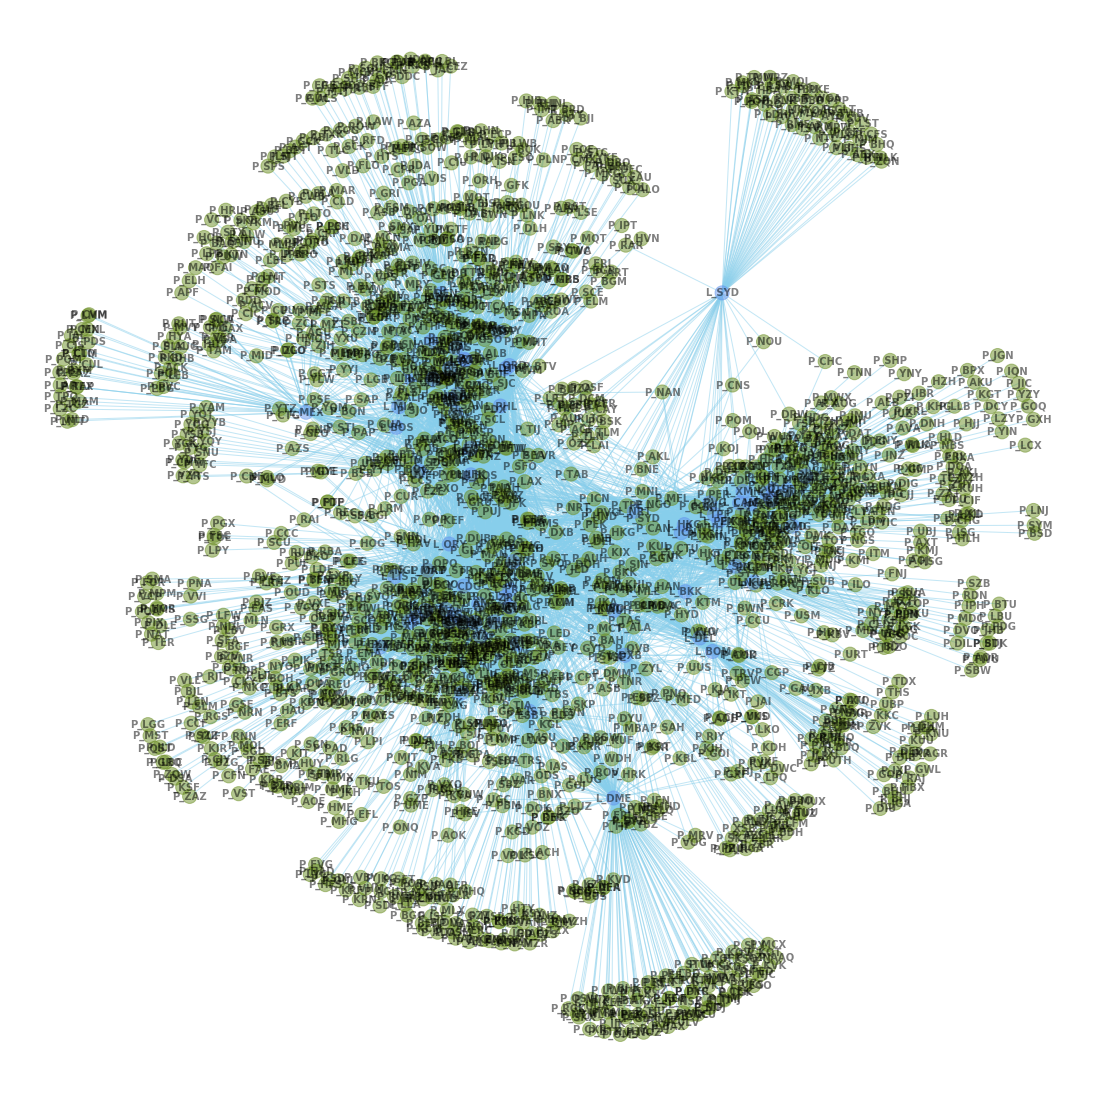

In [301]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G0)  # set colors
#weights = [math.log(edata['attr_dict'][200]) for f, t, edata in G0.edges(data=True)] # set weights

nx.draw(G0, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

We can start to see already how many airports are connected by a much smaller number of airlines (as we would expect).  We can also see how airlnes serve as boundary spanners between airports.Let's raise the water level though to see if we can gain more insight...

#### Graph the Second Largest 'Island' Subgraph - minimum weight level 343

In [248]:
G1=islands[1][1]

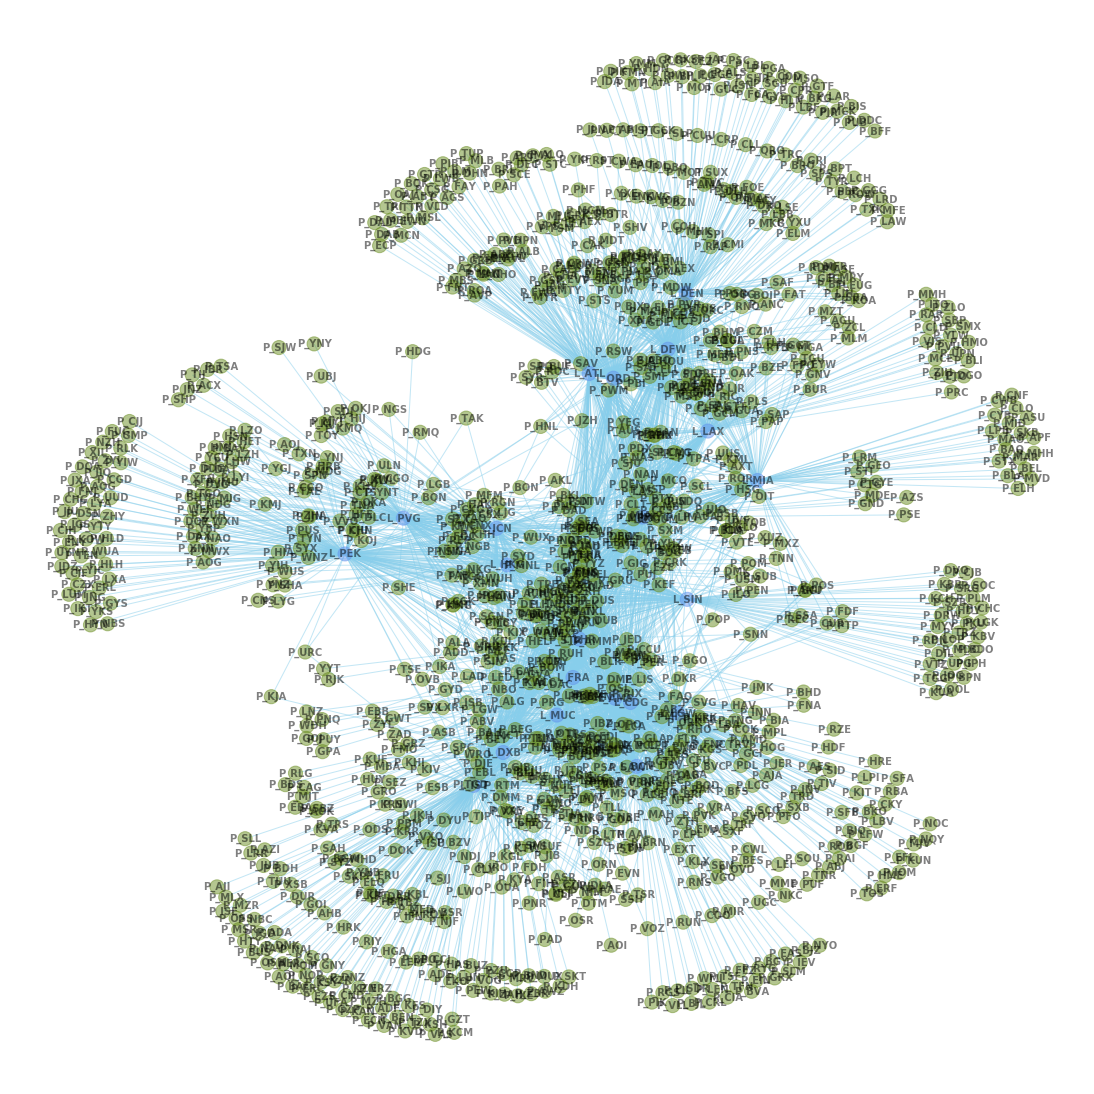

In [302]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G1)  # set colors

nx.draw(G1, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

Major airlines are starting to be visible with the airports that they connect, but a higher water level may make it easier to pick out individual airlines and airports.

#### Graph the Third Largest 'Island' Subgraph - minimum weight level 486

In [250]:
G2=islands[2][1]

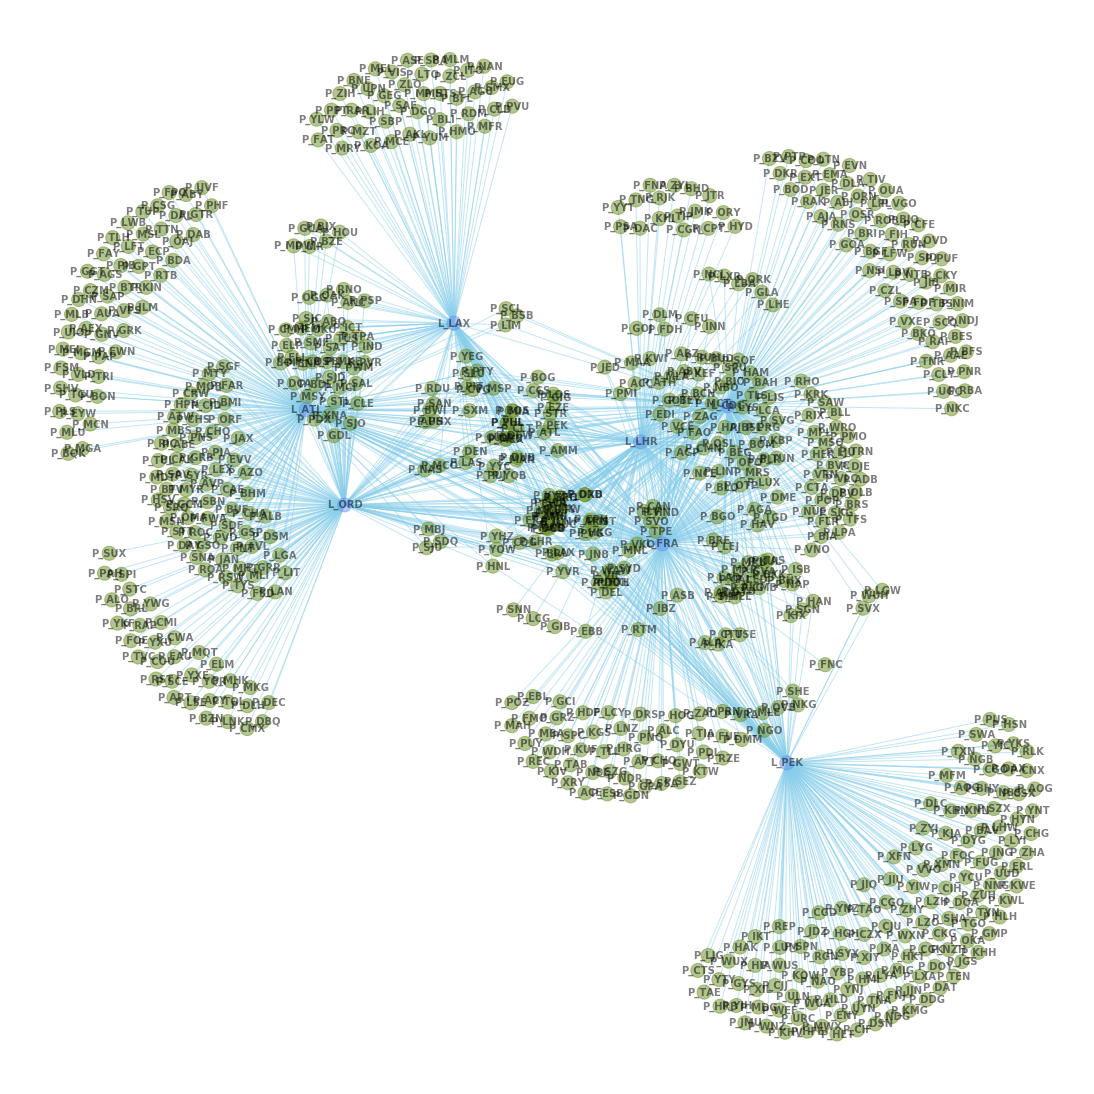

In [305]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G2)  # set colors

nx.draw(G2, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

Here we can really start to see the major airlines in the system: PEK, FAR ORD, ATL, LAX, LHR etc...

#### Graph the Fourth Largest 'Island' Subgraph - minimum weight level 629

In [252]:
G3=islands[3][1]

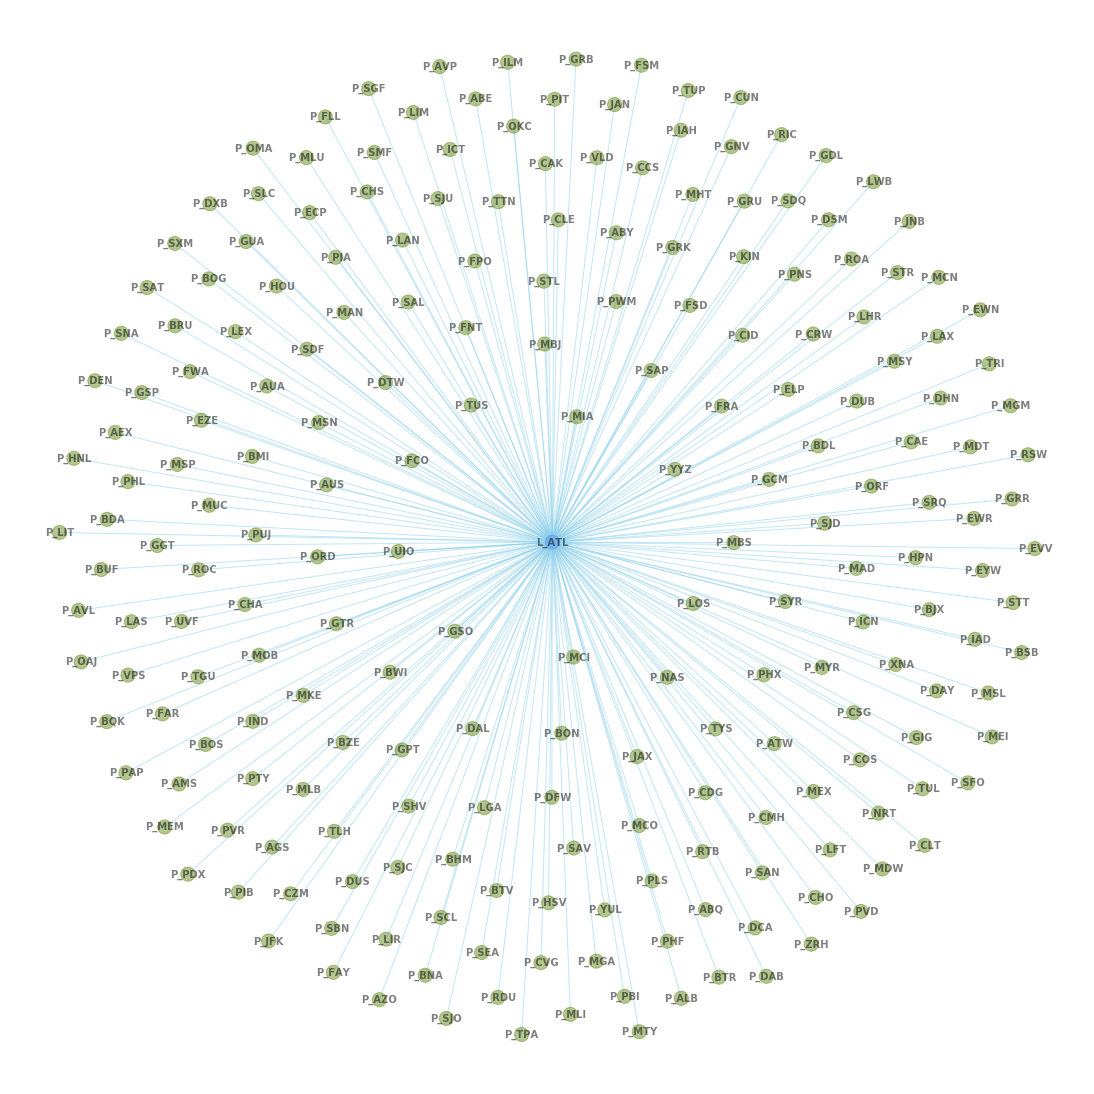

In [304]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G3)  # set colors

nx.draw(G3, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

### Airport Node Projected Graph

In [224]:
# compute an affiliation network of the Airports
airports = bi.weighted_projected_graph(B, airport_nodes)

# Find the largest connected subgraph in the network
#users_subgraph = nx.connected_component_subgraphs(users)[0]  # textbook code doesn't work
airports_subgraph = max(nx.connected_component_subgraphs(airports), key=len)  # alternate method

airports_subgraph.name = "Airports"

print(nx.info(airports_subgraph))

Name: Airports
Type: Graph
Number of nodes: 3196
Number of edges: 326730
Average degree: 204.4618


#### Run island_method function using 3 iterations and a minimum weight 'water line' of 50...

In [254]:
airport_islands = island_method(airports_subgraph, 3, 50)
print('min weight - ', '# of nodes - ', '# of island subgraphs')
for i in airport_islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], '     -     ', len(i[1]), '     -     ', len(list(nx.connected_component_subgraphs(i[1]))))

min weight -  # of nodes -  # of island subgraphs
50      -      130      -      1
104      -      30      -      4
158      -      2      -      1


In [259]:
APG0=max(nx.connected_component_subgraphs(airport_islands[0][1]), key=len)

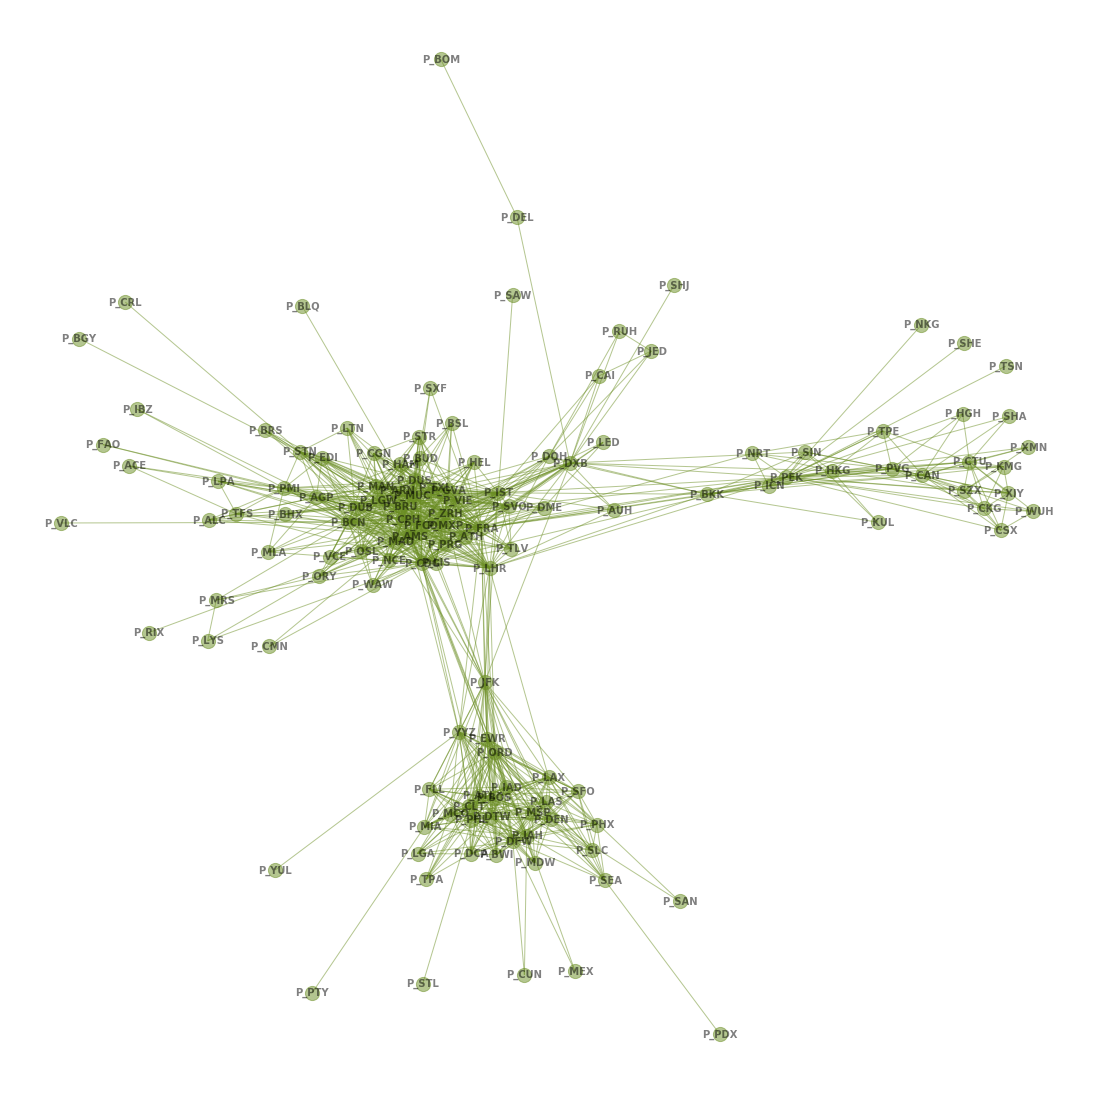

In [291]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

nx.draw(APG0, with_labels=True, node_color='olivedrab', node_size=200, 
        font_size=10, font_weight='bold', edge_color="olivedrab", alpha=0.5)

In [265]:
APG1a=airport_islands[1][1]

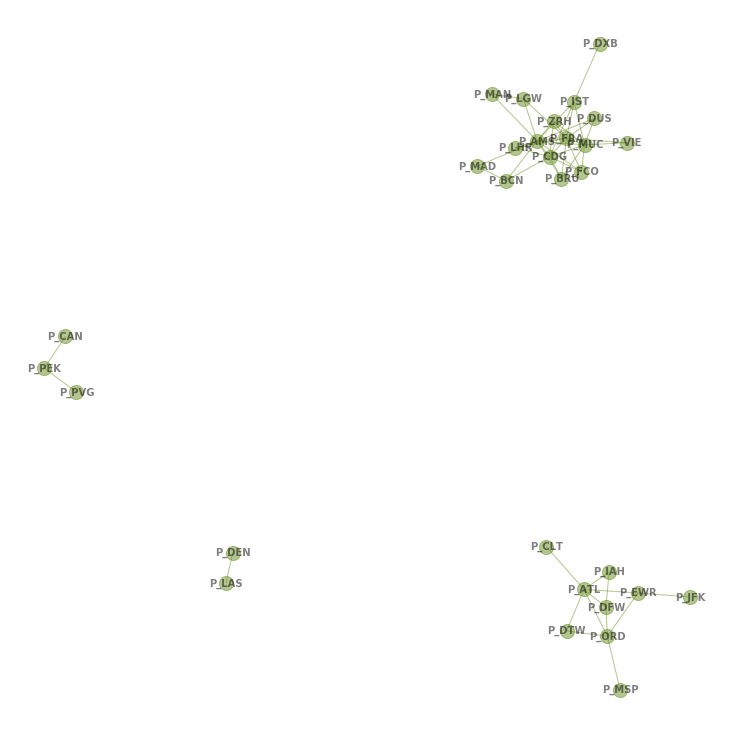

In [290]:
# set plot size
plt.rcParams["figure.figsize"] = (10,10)

nx.draw(APG1a, with_labels=True, node_color='olivedrab', node_size=200, 
        font_size=10, font_weight='bold', edge_color="olivedrab", alpha=0.5)

In [267]:
APG1b=max(nx.connected_component_subgraphs(airport_islands[1][1]), key=len)

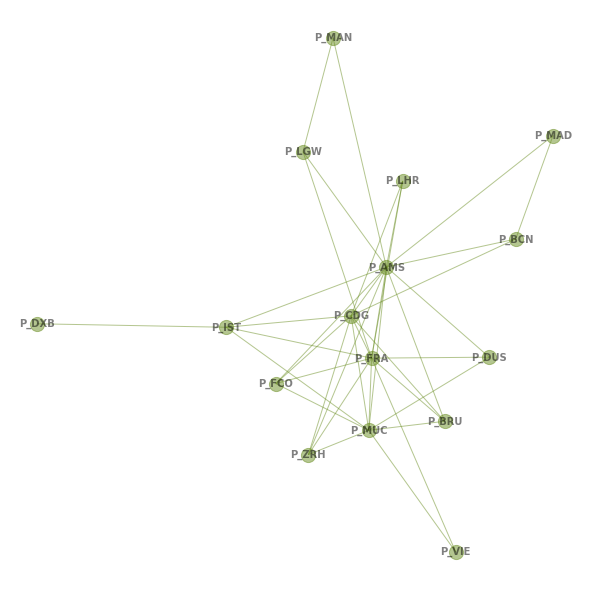

In [289]:
# set plot size
plt.rcParams["figure.figsize"] = (8,8)

nx.draw(APG1b, with_labels=True, node_color='olivedrab', node_size=200, 
        font_size=10, font_weight='bold', edge_color="olivedrab", alpha=0.5)

### Airline Node Projected Graph

In [167]:
# compute an affiliation network of the Airlines
airlines = bi.weighted_projected_graph(B, airline_nodes)

# Find the largest connected subgraph in the network
#users_subgraph = nx.connected_component_subgraphs(users)[0]  # textbook code doesn't work
airlines_subgraph = max(nx.connected_component_subgraphs(airlines), key=len)  # alternate method

airlines_subgraph.name = "Airlines"

print(nx.info(airlines_subgraph))

Name: Airlines
Type: Graph
Number of nodes: 3308
Number of edges: 326563
Average degree: 197.4383


#### Run island_method function using 3 iterations and a minimum weight 'water line' of 50...

In [272]:
airline_islands=island_method(airlines_subgraph, 3, 50)
print('min weight - ', '# of nodes - ', '# of island subgraphs')
for i in airline_islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], '     -     ', len(i[1]), '     -     ', len(list(nx.connected_component_subgraphs(i[1]))))

min weight -  # of nodes -  # of island subgraphs
50      -      126      -      1
103      -      30      -      3
156      -      3      -      1


In [283]:
ALG0=max(nx.connected_component_subgraphs(airline_islands[0][1]), key=len)

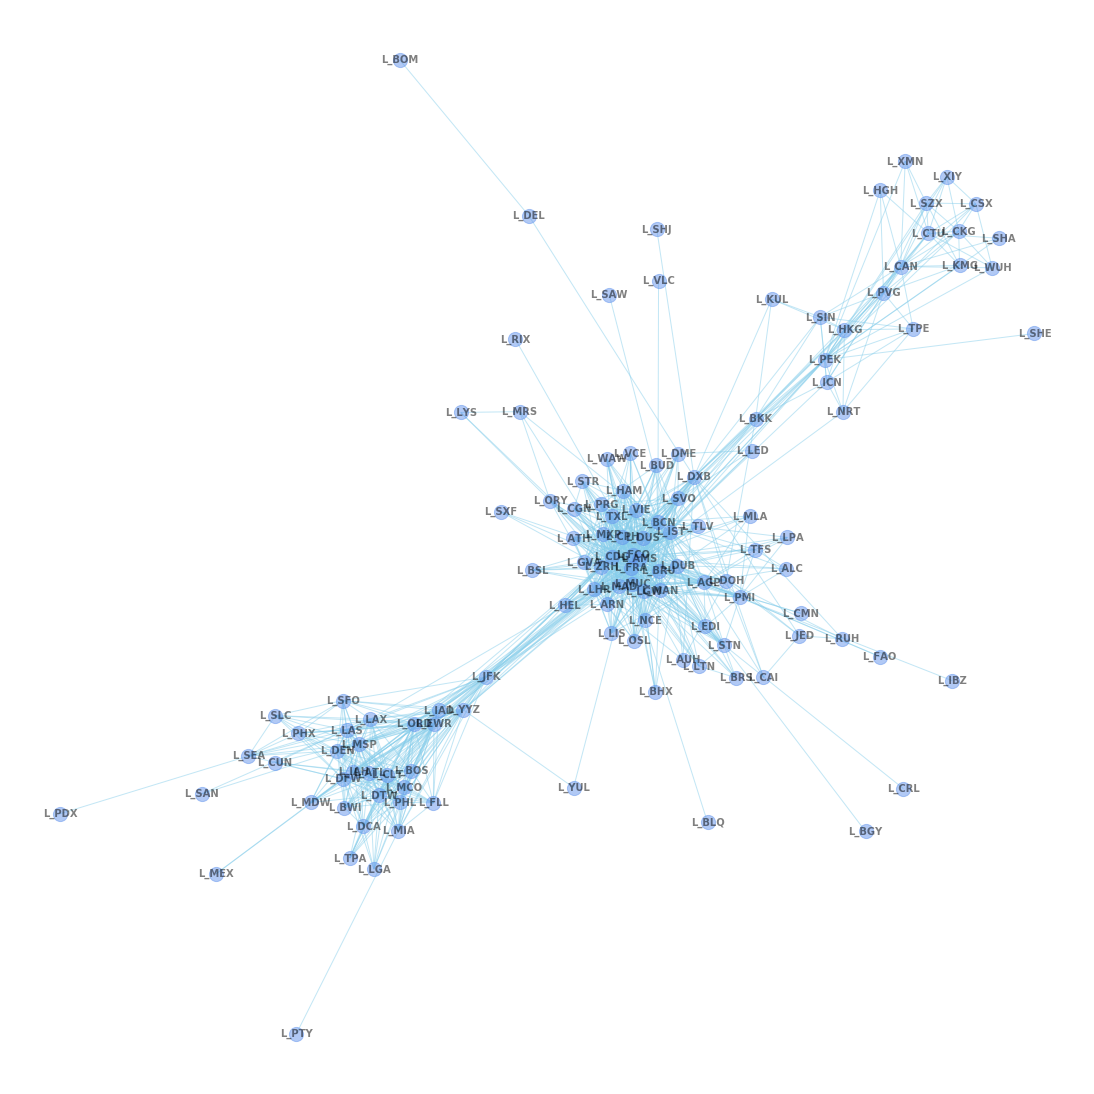

In [285]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

nx.draw(ALG0, with_labels=True, node_color='cornflowerblue', node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

In [277]:
ALG1a=airline_islands[1][1]

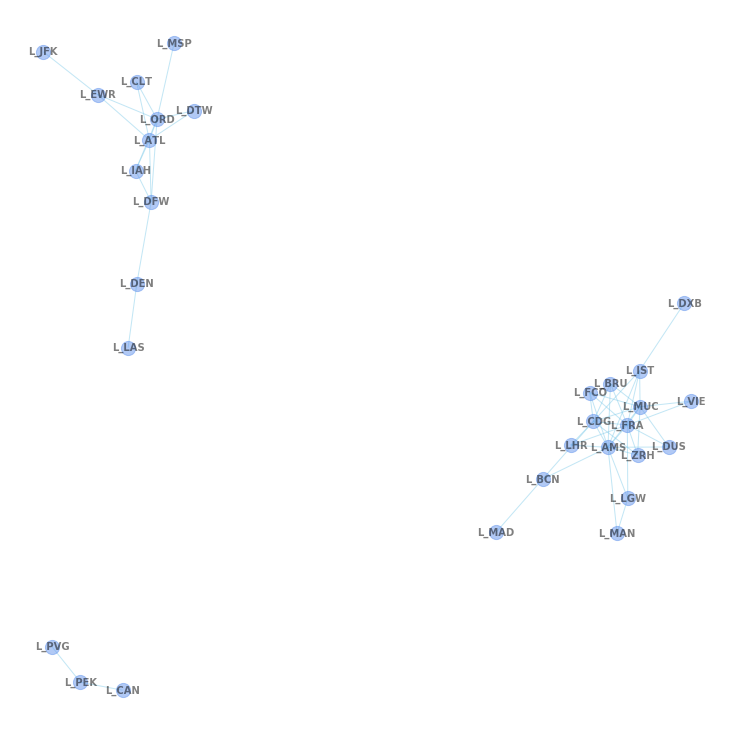

In [287]:
# set plot size
plt.rcParams["figure.figsize"] = (10,10)

nx.draw(ALG1a, with_labels=True, node_color='cornflowerblue', node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

In [279]:
ALG1b=max(nx.connected_component_subgraphs(airline_islands[1][1]), key=len)

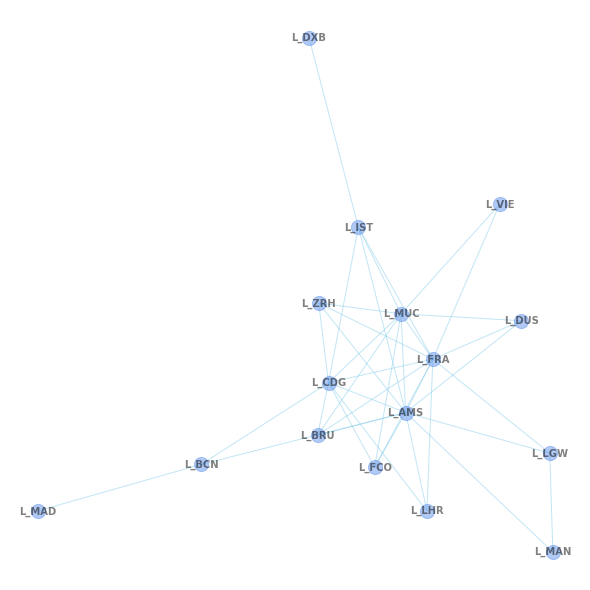

In [288]:
# set plot size
plt.rcParams["figure.figsize"] = (8,8)

nx.draw(ALG1b, with_labels=True, node_color='cornflowerblue', node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)